# Bilateral Model

In [ ]:
%load_ext autoreload
%autoreload 2

from os.path import join
import joblib
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import sys

fp_project_folder = "../../"
sys.path.append(fp_project_folder)

from src.misc import set_seed
from src.display import display_tuning_df
from src.models.bilateral.model import BilateralModel
from src.models.bilateral.tuning import tune_model
from src.models.bilateral.regularizer import SparseRegularizer
from src.models.bilateral.groupedSoftmaxDenseLayer import GroupedSoftmaxDenseLayer

from src.models.bilateral.training.training import transfer_ae, transfer_ae_n_ic
from src.models.bilateral.training.training_ae import train_ae, evaluate_ae
from src.models.bilateral.training.training_ic import train_ic, evaluate_ic
from src.models.bilateral.training.training_fc import train_fc, evaluate_fc
from src.models.bilateral.evaluate import evaluate_final_model
from src.saving import save_hyperparameters, load_hyperparameters, save_predictions, load_predictions
from src.preprocessing.tabular_preprocessing import choose_output_cols


from src.configs.config import input_cols, intermediate_col_dict, tcu_col, \
    le_label, re_label, num_input_cols
from src.configs.config import fp_checkpoint_folder, fp_data_folder

# File Paths
num_epochs_less = 1
ae_model_prev_name = "ae_softmax"
ic_model_prev_name = "ic_softmax"
fc_model_prev_name = "fc_softmax"
new_label = f"_{num_epochs_less}_epochs_less"
ae_model_name = ae_model_prev_name + new_label 
ic_model_name = ic_model_prev_name + new_label 
fc_model_name = fc_model_prev_name + new_label 
fp_col_info_file = join(fp_data_folder, "col_info.joblib")
fp_data_dfs_file = join(fp_data_folder, "data_dfs.joblib")
fp_model_checkpoints = join(fp_checkpoint_folder, "models")
fp_ae_model_checkpoint = join(fp_model_checkpoints, ae_model_name)
fp_ic_model_checkpoint = join(fp_model_checkpoints, ic_model_name)
fp_fc_model_checkpoint = join(fp_model_checkpoints, fc_model_name)

custom_objects={
    "MyRegularizers>SparseRegularizer": SparseRegularizer,
    "MyGroupedSoftmaxDenseLayers>GroupedSoftmaxDenseLayer": GroupedSoftmaxDenseLayer
}

seed_no = 2024
batch_size = 16

print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


## Load Data

In [26]:
data_dfs = joblib.load(fp_data_dfs_file)
col_info = joblib.load(fp_col_info_file)
col_info = choose_output_cols(col_info, bilateral=True)
col_info

{'input_cols': ['Vision Test',
  'VA',
  'IOP',
  'Gradable',
  'Cup Disc Ratio',
  'OCT RNFL_Abnormal (Progressing)',
  'OCT RNFL_Abnormal (Stable)',
  'OCT RNFL_Normal',
  'OCT RNFL_Unreliable',
  'OCT RNFL_nan',
  'MAC GCA_Abnormal (Progressing)',
  'MAC GCA_Abnormal (Stable)',
  'MAC GCA_Normal',
  'MAC GCA_Unreliable',
  'MAC GCA_nan',
  'HVF_Abnormal (Stable)',
  'HVF_Normal',
  'HVF: flat, no IRF/SRF.',
  'HVF_Unreliable',
  'HVF_nan',
  'DRF_DH/MA',
  'DRF_CWS',
  'DRF_BH',
  'DRF_FH',
  'DRF_NVE',
  'DRF_IRMA',
  'DRF_PRH',
  'DRF_10M',
  'DMF_DH/MA',
  'DMF_BH',
  'DMF_Inner',
  'DMF_Better',
  'DMF_HE',
  'AMDF_DDin',
  'AMDF_GT125',
  'AMDF_PA',
  'AMDF_GA',
  'AMDF_PED',
  'AMDF_SFS',
  'AMDF_SR/subRPE',
  'AMDF_CNVM',
  'GSF_RT',
  'GSF_Notch',
  'GSF_CDR',
  'GSF_DA',
  'GSF_DH',
  'OCTM_IRF',
  'OCTM_Normal',
  'OCTM_Atrophy',
  'OCTM_ERMpreservedFC',
  'OCTM_Others',
  'OCTM_ISOSloss',
  'OCTM_VRtraction',
  'OCTM_Drusen',
  'OCTM_ERMdetVA',
  'OCTM_ERMlossFC',
  'OCTM

## Training

In [27]:
def get_num_epochs(tuning_df, num_epochs_less):
    best_epoch = tuning_df.loc[tuning_df["best_hyperparameter"], "best_epoch"].values[0]
    return best_epoch-num_epochs_less

### AE Model

In [28]:
# Load Hyperparameters
ae_best_hyperparameters, ae_tuning_df  = load_hyperparameters(
    name=ae_model_prev_name, fp_checkpoint_folder=fp_checkpoint_folder)
print(ae_best_hyperparameters)
display_tuning_df(ae_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 2, 'intermediate_classifier_width': 5, 'rho': 0.5}


,ae_width,beta,final_classifier_width,intermediate_classifier_width,rho,valid_loss,valid_loss_wo_sparsity,best_epoch,training_time/s,best_hyperparameter
0,64,1.000000,2,5,0.100000,1.534644,0.009766,418,249.348583,False
1,64,1.000000,2,5,0.300000,0.347380,0.006133,245,376.747330,False
2,64,1.000000,2,5,0.500000,0.001437,0.001342,155,253.546263,False
3,128,1.000000,2,5,0.100000,3.069081,0.020215,282,432.049020,False
4,128,1.000000,2,5,0.300000,0.687097,0.005153,285,413.161770,False
5,128,1.000000,2,5,0.500000,0.001364,0.001281,103,187.128570,False
6,256,1.000000,2,5,0.100000,6.107487,0.009977,235,407.397454,False
7,256,1.000000,2,5,0.300000,1.371410,0.007776,278,443.117501,False
8,256,1.000000,2,5,0.500000,0.001004,0.000955,90,160.700252,True


#### Training

Epoch 1/89
85/85 [==============================] - 1s 7ms/step - loss: 0.0306 - mse: 0.0270 - val_loss: 0.0109 - val_mse: 0.0094
Epoch 2/89
85/85 [==============================] - 0s 5ms/step - loss: 0.0088 - mse: 0.0078 - val_loss: 0.0066 - val_mse: 0.0057
Epoch 3/89
85/85 [==============================] - 0s 5ms/step - loss: 0.0055 - mse: 0.0048 - val_loss: 0.0044 - val_mse: 0.0038
Epoch 4/89
85/85 [==============================] - 0s 5ms/step - loss: 0.0039 - mse: 0.0034 - val_loss: 0.0041 - val_mse: 0.0035
Epoch 5/89
85/85 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0030 - val_loss: 0.0035 - val_mse: 0.0030
Epoch 6/89
85/85 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0025 - val_loss: 0.0030 - val_mse: 0.0026
Epoch 7/89
85/85 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0023 - val_loss: 0.0029 - val_mse: 0.0025
Epoch 8/89
85/85 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.00

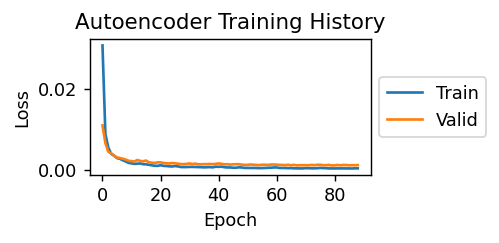

6/6 [==============================] - 0s 2ms/step


,Train,Valid,Test
Autoencoder MSE,0.000306,0.001105,0.001737


,Vision Test,VA,IOP,Gradable,Cup Disc Ratio,OCT RNFL_Abnormal (Progressing),OCT RNFL_Abnormal (Stable),OCT RNFL_Normal,OCT RNFL_Unreliable,OCT RNFL_nan,...,OCTM_ISOSloss_pred,OCTM_VRtraction_pred,OCTM_Drusen_pred,OCTM_ERMdetVA_pred,OCTM_ERMlossFC_pred,OCTM_SRF_pred,OCTM_Ungradable_pred,OCTM_Lamellar_pred,OCTM_IRHM_pred,split
0,1.0,0.000000,0.769231,1.0,0.894737,1.0,0.0,0.0,0.0,0.0,...,-0.030072,0.014905,0.027875,-0.013126,0.319114,-0.017944,0.000421,0.002545,0.026776,train
1,0.0,0.000000,0.307692,1.0,0.736842,0.0,0.0,0.0,0.0,1.0,...,-0.001518,-0.000292,0.009381,0.001119,0.006067,-0.002662,-0.002702,0.003040,-0.005080,train
2,1.0,0.000000,0.461538,1.0,0.736842,0.0,0.0,0.0,0.0,1.0,...,-0.001754,0.000608,0.003076,0.000056,0.000471,-0.008076,-0.002150,-0.001737,-0.005028,train
3,0.0,0.222222,0.461538,1.0,0.842105,0.0,0.0,0.0,0.0,1.0,...,0.828282,-0.009567,-0.014730,0.002187,-0.003694,0.008335,-0.000090,-0.003679,0.005061,train
4,0.0,0.333333,0.692308,1.0,0.684211,0.0,0.0,0.0,0.0,1.0,...,-0.001481,-0.001300,0.007843,-0.000907,0.005657,-0.001868,-0.005811,0.005778,0.000184,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,0.0,0.000000,0.666667,1.0,0.777778,0.0,0.0,0.0,0.0,1.0,...,-0.006752,0.000493,0.002690,-0.000343,0.030055,0.008783,0.002697,0.003111,0.003215,test
1692,0.0,0.500000,0.400000,1.0,0.944444,0.0,1.0,0.0,0.0,0.0,...,-0.045326,0.023143,-0.018931,0.017842,0.122849,0.004253,0.018824,0.018160,0.007229,test
1693,0.0,0.000000,0.333333,1.0,0.777778,0.0,0.0,0.0,0.0,1.0,...,-0.000618,0.000753,0.008189,0.000327,-0.010733,-0.005441,-0.005093,-0.004304,0.000176,test
1694,0.0,0.333333,0.400000,1.0,0.888889,0.0,0.0,0.0,0.0,1.0,...,-0.004291,-0.001141,0.002008,0.000881,0.003306,-0.014586,0.001729,0.001796,0.000743,test


In [29]:
set_seed(seed_no)
ae_bilateral_model = BilateralModel(**col_info, **ae_best_hyperparameters)
train_ae(
    ae_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=get_num_epochs(ae_tuning_df, num_epochs_less), patience=20, verbose=1, seed=seed_no
)
ae_perf_df, ae_pred_df = evaluate_ae(ae_bilateral_model, **data_dfs)
display(ae_perf_df)
display(ae_pred_df)

In [30]:
save_predictions(
    prediction_df=ae_pred_df, 
    name=ae_model_name, fp_checkpoint_folder=fp_checkpoint_folder
)

Predictions Saved!


In [31]:
# Save model
ae_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
ae_bilateral_model.save(fp_ae_model_checkpoint)

INFO:tensorflow:Assets written to: ../checkpoints\models\ae_softmax_1_epochs_less\assets


INFO:tensorflow:Assets written to: ../checkpoints\models\ae_softmax_1_epochs_less\assets


In [32]:
# Load model
ae_bilateral_model = tf.keras.models.load_model(
    fp_ae_model_checkpoint, custom_objects=custom_objects)
ae_perf_df, ae_pred_df = evaluate_ae(ae_bilateral_model, **data_dfs)
display(ae_perf_df)
display(ae_pred_df)

6/6 [==============================] - 0s 1ms/step


,Train,Valid,Test
Autoencoder MSE,0.000306,0.001105,0.001737


,Vision Test,VA,IOP,Gradable,Cup Disc Ratio,OCT RNFL_Abnormal (Progressing),OCT RNFL_Abnormal (Stable),OCT RNFL_Normal,OCT RNFL_Unreliable,OCT RNFL_nan,...,OCTM_ISOSloss_pred,OCTM_VRtraction_pred,OCTM_Drusen_pred,OCTM_ERMdetVA_pred,OCTM_ERMlossFC_pred,OCTM_SRF_pred,OCTM_Ungradable_pred,OCTM_Lamellar_pred,OCTM_IRHM_pred,split
0,1.0,0.000000,0.769231,1.0,0.894737,1.0,0.0,0.0,0.0,0.0,...,-0.030072,0.014905,0.027875,-0.013126,0.319114,-0.017944,0.000421,0.002545,0.026776,train
1,0.0,0.000000,0.307692,1.0,0.736842,0.0,0.0,0.0,0.0,1.0,...,-0.001518,-0.000292,0.009381,0.001119,0.006067,-0.002662,-0.002702,0.003040,-0.005080,train
2,1.0,0.000000,0.461538,1.0,0.736842,0.0,0.0,0.0,0.0,1.0,...,-0.001754,0.000608,0.003076,0.000056,0.000471,-0.008076,-0.002150,-0.001737,-0.005028,train
3,0.0,0.222222,0.461538,1.0,0.842105,0.0,0.0,0.0,0.0,1.0,...,0.828282,-0.009567,-0.014730,0.002187,-0.003694,0.008335,-0.000090,-0.003679,0.005061,train
4,0.0,0.333333,0.692308,1.0,0.684211,0.0,0.0,0.0,0.0,1.0,...,-0.001481,-0.001300,0.007843,-0.000907,0.005657,-0.001868,-0.005811,0.005778,0.000184,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,0.0,0.000000,0.666667,1.0,0.777778,0.0,0.0,0.0,0.0,1.0,...,-0.006752,0.000493,0.002690,-0.000343,0.030055,0.008783,0.002697,0.003111,0.003215,test
1692,0.0,0.500000,0.400000,1.0,0.944444,0.0,1.0,0.0,0.0,0.0,...,-0.045326,0.023143,-0.018931,0.017842,0.122849,0.004253,0.018824,0.018160,0.007229,test
1693,0.0,0.000000,0.333333,1.0,0.777778,0.0,0.0,0.0,0.0,1.0,...,-0.000618,0.000753,0.008189,0.000327,-0.010733,-0.005441,-0.005093,-0.004304,0.000176,test
1694,0.0,0.333333,0.400000,1.0,0.888889,0.0,0.0,0.0,0.0,1.0,...,-0.004291,-0.001141,0.002008,0.000881,0.003306,-0.014586,0.001729,0.001796,0.000743,test


### Intermediate Classifier Model

In [33]:
# Load Hyperparameters
ic_best_hyperparameters, ic_tuning_df  = load_hyperparameters(
    name=ic_model_prev_name, fp_checkpoint_folder=fp_checkpoint_folder)
print(ic_best_hyperparameters)
display_tuning_df(ic_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 2, 'intermediate_classifier_width': 768, 'rho': 0.5}


,ae_width,beta,final_classifier_width,intermediate_classifier_width,rho,valid_loss,valid_loss_wo_sparsity,best_epoch,training_time/s,best_hyperparameter
0,256,1.000000,2,512,0.500000,0.877941,0.877892,4,78.934741,False
1,256,1.000000,2,768,0.500000,0.874480,0.874431,2,77.478317,True
2,256,1.000000,2,1024,0.500000,0.893720,0.893671,2,70.483687,False


#### Training

85/85 [==============================] - 4s 26ms/step - loss: 2.1525 - intermediate_classifier_loss: 0.5447 - intermediate_classifier_1_loss: 0.5863 - intermediate_classifier_2_loss: 0.7470 - intermediate_classifier_3_loss: 0.2744 - intermediate_classifier_categorical_crossentropy: 0.5447 - intermediate_classifier_accuracy: 0.8400 - intermediate_classifier_1_categorical_crossentropy: 0.5863 - intermediate_classifier_1_accuracy: 0.7891 - intermediate_classifier_2_categorical_crossentropy: 0.7470 - intermediate_classifier_2_accuracy: 0.7699 - intermediate_classifier_3_categorical_crossentropy: 0.2744 - intermediate_classifier_3_accuracy: 0.9388 - val_loss: 1.0147 - val_intermediate_classifier_loss: 0.2300 - val_intermediate_classifier_1_loss: 0.3871 - val_intermediate_classifier_2_loss: 0.3479 - val_intermediate_classifier_3_loss: 0.0497 - val_intermediate_classifier_categorical_crossentropy: 0.2300 - val_intermediate_classifier_accuracy: 0.9353 - val_intermediate_classifier_1_categorica

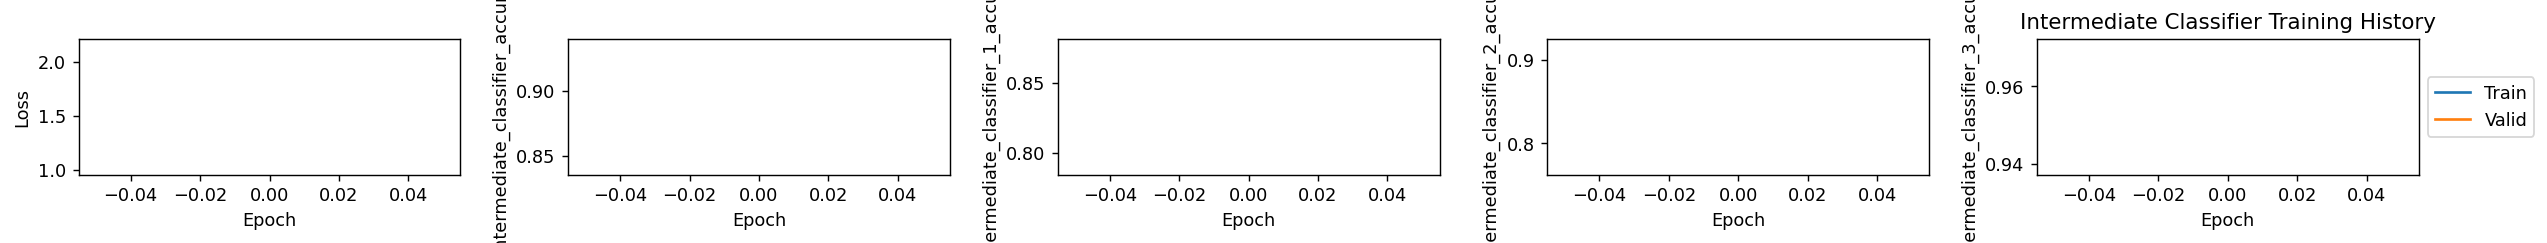

6/6 [==============================] - 0s 8ms/step


,Train,Valid,Test
DMC Categorical_crossentropy,0.189553,0.229963,0.191504
AMDC Categorical_crossentropy,0.267043,0.387084,0.431874
DRC Categorical_crossentropy,0.455933,0.347907,0.447561
GSC Categorical_crossentropy,0.126225,0.049675,0.118322
DMC Accuracy,0.938791,0.935294,0.941176
AMDC Accuracy,0.915192,0.876471,0.864706
DRC Accuracy,0.845133,0.917647,0.864706
GSC Accuracy,0.946165,0.970588,0.952941
DMC F1_score,0.629775,0.516038,0.604513
AMDC F1_score,0.463348,0.538986,0.659154


,DMC_M0,DMC_M1,DMC_M2,DMC_M3,DMC_M4,DMC_NA,AMDC_No,AMDC_Early,AMDC_Intermediate,AMDC_Advanced_1,...,DRC_MildNPDR_pred,DRC_ModerateNPDR_pred,DRC_SevereNPDR_pred,DRC_ProliferativeDR_pred,DRC_Unreadable_pred,DRC_NA_pred,GSC_G0_pred,GSC_G1_pred,GSC_NA_pred,split
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.006681,0.000945,0.000019,0.000002,0.000158,1.805410e-07,0.408173,0.348436,2.433904e-01,train
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.011551,0.002608,0.000110,0.000016,0.000629,2.986651e-06,0.997779,0.002193,2.787323e-05,train
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.031833,0.012011,0.000971,0.000237,0.003915,6.437512e-05,0.997984,0.001991,2.412548e-05,train
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.929414,0.068137,0.001375,0.000025,0.000158,1.949135e-06,0.999890,0.000110,1.397848e-07,train
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.013598,0.003340,0.000159,0.000026,0.000862,5.084512e-06,0.998462,0.001524,1.478106e-05,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.892212,0.103127,0.003219,0.000078,0.000374,8.108266e-06,0.999952,0.000048,3.655239e-08,test
1692,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.005404,0.000945,0.000036,0.000004,0.000307,6.364322e-07,0.365804,0.342238,2.919588e-01,test
1693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.005220,0.000857,0.000021,0.000002,0.000169,3.079637e-07,0.998276,0.001706,1.728947e-05,test
1694,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.018151,0.005432,0.000328,0.000065,0.001613,1.467588e-05,0.994544,0.005325,1.303315e-04,test


In [34]:
set_seed(seed_no)
ic_bilateral_model = BilateralModel(**col_info, **ic_best_hyperparameters)
ic_bilateral_model = transfer_ae(base_bilateral_model=ae_bilateral_model, new_bilateral_model=ic_bilateral_model)
train_ic(
    ic_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=get_num_epochs(ic_tuning_df, num_epochs_less), 
    patience=20, verbose=1, seed=seed_no
)
ic_perf_df, ic_pred_df = evaluate_ic(ic_bilateral_model, **data_dfs)
display(ic_perf_df)
display(ic_pred_df)

In [38]:
# Save model
ic_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
ic_bilateral_model.save(fp_ic_model_checkpoint)

INFO:tensorflow:Assets written to: ../checkpoints\models\ic_softmax_1_epochs_less\assets


INFO:tensorflow:Assets written to: ../checkpoints\models\ic_softmax_1_epochs_less\assets


In [39]:
ic_bilateral_model = tf.keras.models.load_model(fp_ic_model_checkpoint, custom_objects=custom_objects)
ic_perf_df, ic_pred_df = evaluate_ic(ic_bilateral_model, **data_dfs)
display(ic_perf_df)
display(ic_pred_df)

6/6 [==============================] - 0s 7ms/step


,Train,Valid,Test
DMC Categorical_crossentropy,0.189553,0.229963,0.191504
AMDC Categorical_crossentropy,0.267043,0.387084,0.431874
DRC Categorical_crossentropy,0.455933,0.347907,0.447561
GSC Categorical_crossentropy,0.126225,0.049675,0.118322
DMC Accuracy,0.938791,0.935294,0.941176
AMDC Accuracy,0.915192,0.876471,0.864706
DRC Accuracy,0.845133,0.917647,0.864706
GSC Accuracy,0.946165,0.970588,0.952941
DMC F1_score,0.629775,0.516038,0.604513
AMDC F1_score,0.463348,0.538986,0.659154


,DMC_M0,DMC_M1,DMC_M2,DMC_M3,DMC_M4,DMC_NA,AMDC_No,AMDC_Early,AMDC_Intermediate,AMDC_Advanced_1,...,DRC_MildNPDR_pred,DRC_ModerateNPDR_pred,DRC_SevereNPDR_pred,DRC_ProliferativeDR_pred,DRC_Unreadable_pred,DRC_NA_pred,GSC_G0_pred,GSC_G1_pred,GSC_NA_pred,split
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.006681,0.000945,0.000019,0.000002,0.000158,1.805410e-07,0.408173,0.348436,2.433904e-01,train
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.011551,0.002608,0.000110,0.000016,0.000629,2.986651e-06,0.997779,0.002193,2.787323e-05,train
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.031833,0.012011,0.000971,0.000237,0.003915,6.437512e-05,0.997984,0.001991,2.412548e-05,train
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.929414,0.068137,0.001375,0.000025,0.000158,1.949135e-06,0.999890,0.000110,1.397848e-07,train
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.013598,0.003340,0.000159,0.000026,0.000862,5.084512e-06,0.998462,0.001524,1.478106e-05,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.892212,0.103127,0.003219,0.000078,0.000374,8.108266e-06,0.999952,0.000048,3.655239e-08,test
1692,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.005404,0.000945,0.000036,0.000004,0.000307,6.364322e-07,0.365804,0.342238,2.919588e-01,test
1693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.005220,0.000857,0.000021,0.000002,0.000169,3.079637e-07,0.998276,0.001706,1.728947e-05,test
1694,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.018151,0.005432,0.000328,0.000065,0.001613,1.467588e-05,0.994544,0.005325,1.303315e-04,test


In [40]:
save_predictions(prediction_df=ic_pred_df, name=ic_model_name, fp_checkpoint_folder=fp_checkpoint_folder)

Predictions Saved!


### Final Classifier Model

In [41]:
# Load Hyperparameters
fc_best_hyperparameters, fc_tuning_df  = load_hyperparameters(
    name=fc_model_prev_name, fp_checkpoint_folder=fp_checkpoint_folder)
print(fc_best_hyperparameters)
display_tuning_df(fc_tuning_df)

{'ae_width': 256, 'beta': 1.0, 'final_classifier_width': 32, 'intermediate_classifier_width': 768, 'rho': 0.5}


,ae_width,beta,final_classifier_width,intermediate_classifier_width,rho,valid_loss,valid_loss_wo_sparsity,best_epoch,training_time/s,best_hyperparameter
0,256,1.000000,32,768,0.500000,0.158841,0.158702,41,80.120065,True
1,256,1.000000,48,768,0.500000,0.161506,0.161368,26,62.739115,False
2,256,1.000000,64,768,0.500000,0.161155,0.161017,26,64.085033,False
3,256,1.000000,80,768,0.500000,0.161082,0.160944,32,69.581012,False
4,256,1.000000,96,768,0.500000,0.159230,0.159092,15,52.631513,False


#### Training

Epoch 1/40
43/43 [==============================] - 2s 19ms/step - loss: 0.9145 - binary_crossentropy: 0.9144 - binary_accuracy: 0.2245 - val_loss: 0.6510 - val_binary_crossentropy: 0.6509 - val_binary_accuracy: 0.5694
Epoch 2/40
43/43 [==============================] - 0s 9ms/step - loss: 0.4461 - binary_crossentropy: 0.4460 - binary_accuracy: 0.8549 - val_loss: 0.3215 - val_binary_crossentropy: 0.3214 - val_binary_accuracy: 0.9082
Epoch 3/40
43/43 [==============================] - 0s 8ms/step - loss: 0.2672 - binary_crossentropy: 0.2671 - binary_accuracy: 0.9183 - val_loss: 0.2702 - val_binary_crossentropy: 0.2701 - val_binary_accuracy: 0.9059
Epoch 4/40
43/43 [==============================] - 0s 8ms/step - loss: 0.2234 - binary_crossentropy: 0.2233 - binary_accuracy: 0.9174 - val_loss: 0.2604 - val_binary_crossentropy: 0.2602 - val_binary_accuracy: 0.9059
Epoch 5/40
43/43 [==============================] - 0s 8ms/step - loss: 0.2040 - binary_crossentropy: 0.2039 - binary_accuracy:

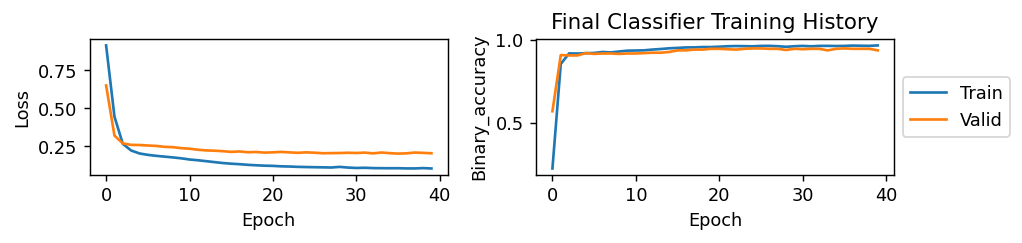

3/3 [==============================] - 0s 9ms/step


,Train,Valid,Test
Accuracy Total_Time >= 1.0,0.000,0.000,NaN
Accuracy Total_Time >= 13.0,0.360,0.364,0.250
Accuracy Total_Time >= 26.0,0.956,0.964,0.963
Accuracy Total_Time >= 4.33,0.851,0.600,0.875
Accuracy Total_Time >= 52.0,0.988,0.974,1.000
Final Classifier Accuracy,0.863,0.847,0.871
Final Classifier Bin Accuracy,0.963,0.936,0.965
Final Classifier Crossentropy,0.104,0.205,0.105
Total_Time >= 1.0 Proportion,0.004,0.024,0.000
Total_Time >= 13.0 Proportion,0.164,0.129,0.141


,Total_Time >= 1.0,Total_Time >= 4.33,Total_Time >= 13.0,Total_Time >= 26.0,Total_Time >= 52.0,Total_Time >= 1.0_pred,Total_Time >= 4.33_pred,Total_Time >= 13.0_pred,Total_Time >= 26.0_pred,Total_Time >= 52.0_pred,split
0,1.0,1.0,1.0,0.0,0.0,0.999791,0.990890,0.927498,0.003610,0.000361,train
1,1.0,1.0,1.0,1.0,1.0,0.999804,0.997679,0.997799,0.965873,0.977071,train
2,1.0,1.0,1.0,1.0,1.0,0.999784,0.997583,0.997195,0.946841,0.947913,train
3,1.0,1.0,1.0,1.0,0.0,0.999548,0.999033,0.979345,0.786559,0.000004,train
4,1.0,1.0,1.0,1.0,1.0,0.999805,0.997692,0.997812,0.966154,0.977326,train
...,...,...,...,...,...,...,...,...,...,...,...
843,1.0,1.0,1.0,1.0,0.0,0.999843,0.999689,0.996077,0.924999,0.000038,test
844,1.0,1.0,1.0,0.0,0.0,0.999788,0.991239,0.934380,0.005398,0.000588,test
845,1.0,1.0,1.0,1.0,1.0,0.999169,0.995707,0.996898,0.964505,0.975231,test
846,1.0,1.0,1.0,1.0,0.0,0.999823,0.998524,0.995913,0.920177,0.004952,test


In [44]:
set_seed(seed_no)
fc_bilateral_model = BilateralModel(**col_info, **fc_best_hyperparameters,)
fc_bilateral_model = transfer_ae_n_ic(base_bilateral_model=ic_bilateral_model, new_bilateral_model=fc_bilateral_model)
train_fc(
    fc_bilateral_model, **data_dfs,
    batch_size=batch_size, max_epochs=get_num_epochs(fc_tuning_df, num_epochs_less), 
    patience=20, verbose=1, seed=seed_no
)
fc_perf_df, fc_pred_df = evaluate_fc(fc_bilateral_model, **data_dfs)
display(fc_perf_df)
display(fc_pred_df)

In [45]:
# Save model
fc_bilateral_model(tf.random.normal((2,num_input_cols)), tf.random.normal((2,num_input_cols)))
fc_bilateral_model.save(fp_fc_model_checkpoint)

INFO:tensorflow:Assets written to: ../checkpoints\models\fc_softmax_1_epochs_less\assets


INFO:tensorflow:Assets written to: ../checkpoints\models\fc_softmax_1_epochs_less\assets


In [46]:
# Load model
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint, custom_objects=custom_objects)
fc_perf_df, fc_pred_df = evaluate_fc(fc_bilateral_model, **data_dfs)
display(fc_perf_df)
display(fc_pred_df)

3/3 [==============================] - 0s 10ms/step


,Train,Valid,Test
Accuracy Total_Time >= 1.0,0.000,0.000,NaN
Accuracy Total_Time >= 13.0,0.360,0.364,0.250
Accuracy Total_Time >= 26.0,0.956,0.964,0.963
Accuracy Total_Time >= 4.33,0.851,0.600,0.875
Accuracy Total_Time >= 52.0,0.988,0.974,1.000
Final Classifier Accuracy,0.863,0.847,0.871
Final Classifier Bin Accuracy,0.963,0.936,0.965
Final Classifier Crossentropy,0.104,0.205,0.105
Total_Time >= 1.0 Proportion,0.004,0.024,0.000
Total_Time >= 13.0 Proportion,0.164,0.129,0.141


,Total_Time >= 1.0,Total_Time >= 4.33,Total_Time >= 13.0,Total_Time >= 26.0,Total_Time >= 52.0,Total_Time >= 1.0_pred,Total_Time >= 4.33_pred,Total_Time >= 13.0_pred,Total_Time >= 26.0_pred,Total_Time >= 52.0_pred,split
0,1.0,1.0,1.0,0.0,0.0,0.999791,0.990890,0.927498,0.003610,0.000361,train
1,1.0,1.0,1.0,1.0,1.0,0.999804,0.997679,0.997799,0.965873,0.977071,train
2,1.0,1.0,1.0,1.0,1.0,0.999784,0.997583,0.997195,0.946841,0.947913,train
3,1.0,1.0,1.0,1.0,0.0,0.999548,0.999033,0.979345,0.786559,0.000004,train
4,1.0,1.0,1.0,1.0,1.0,0.999805,0.997692,0.997812,0.966154,0.977326,train
...,...,...,...,...,...,...,...,...,...,...,...
843,1.0,1.0,1.0,1.0,0.0,0.999843,0.999689,0.996077,0.924999,0.000038,test
844,1.0,1.0,1.0,0.0,0.0,0.999788,0.991239,0.934380,0.005398,0.000588,test
845,1.0,1.0,1.0,1.0,1.0,0.999169,0.995707,0.996898,0.964505,0.975231,test
846,1.0,1.0,1.0,1.0,0.0,0.999823,0.998524,0.995913,0.920177,0.004952,test


In [47]:
save_predictions(prediction_df=fc_pred_df, name=fc_model_name, fp_checkpoint_folder=fp_checkpoint_folder)

Predictions Saved!


In [48]:
fc_pred_df = load_predictions(name=fc_model_name, fp_checkpoint_folder=fp_checkpoint_folder)
fc_pred_df.head()

,Total_Time >= 1.0,Total_Time >= 4.33,Total_Time >= 13.0,Total_Time >= 26.0,Total_Time >= 52.0,Total_Time >= 1.0_pred,Total_Time >= 4.33_pred,Total_Time >= 13.0_pred,Total_Time >= 26.0_pred,Total_Time >= 52.0_pred,split
0,1.0,1.0,1.0,0.0,0.0,0.999791,0.990890,0.927498,0.003610,0.000361,train
1,1.0,1.0,1.0,1.0,1.0,0.999804,0.997679,0.997799,0.965873,0.977071,train
2,1.0,1.0,1.0,1.0,1.0,0.999784,0.997583,0.997195,0.946841,0.947913,train
3,1.0,1.0,1.0,1.0,0.0,0.999548,0.999033,0.979345,0.786559,0.000004,train
4,1.0,1.0,1.0,1.0,1.0,0.999805,0.997692,0.997812,0.966154,0.977326,train


## Evaluation + Prediction

In [49]:
fc_bilateral_model = tf.keras.models.load_model(fp_fc_model_checkpoint, custom_objects=custom_objects)

,M0,M1,M2,M3,M4,NA
M0,95,0,0,0,0,2
M1,0,3,0,0,0,0
M2,1,0,59,0,0,0
M3,1,0,0,0,0,0
M4,0,1,3,0,2,0
NA,2,0,0,0,0,1


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,94,1,0,0,0,0
Early,20,36,0,0,0,0
Intermediate,1,0,17,0,0,0
Advanced 1,1,0,0,0,0,0
Advanced 2,0,0,0,0,0,0
NA,0,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,83,0,0,0,0,0,0
Mild NPDR,9,57,5,0,0,0,0
Moderate NPDR,1,4,7,0,0,0,0
Severe NPDR,1,0,2,0,0,0,0
Proliferative DR,0,0,0,0,0,0,0
Unreadable,1,0,0,0,0,0,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,162,0,0
G1,8,0,0
NA,0,0,0


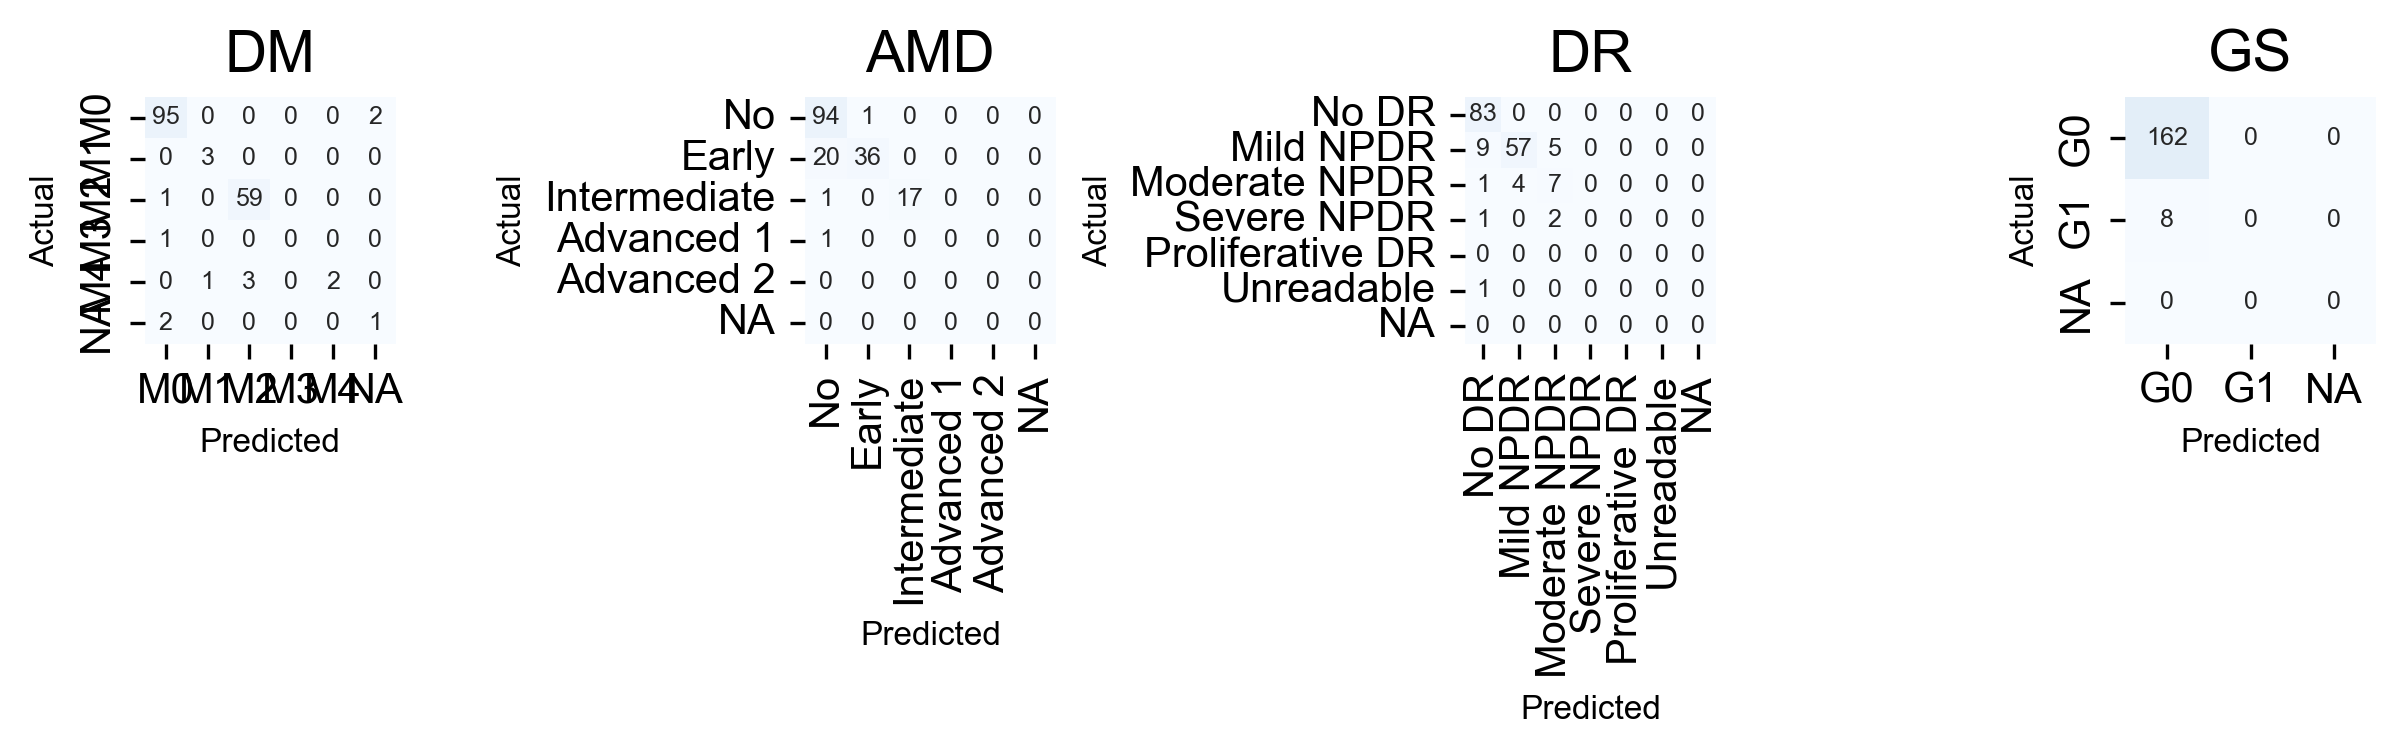

,M0,M1,M2,M3,M4,NA
M0,95,0,0,0,0,2
M1,0,3,0,0,0,0
M2,1,0,59,0,0,0
M3,1,0,0,0,0,0
M4,0,1,3,0,2,0
NA,2,0,0,0,0,1


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,94,1,0,0,0,0
Early,20,36,0,0,0,0
Intermediate,1,0,17,0,0,0
Advanced 1,1,0,0,0,0,0
Advanced 2,0,0,0,0,0,0
NA,0,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,83,0,0,0,0,0,0
Mild NPDR,9,57,5,0,0,0,0
Moderate NPDR,1,4,7,0,0,0,0
Severe NPDR,1,0,2,0,0,0,0
Proliferative DR,0,0,0,0,0,0,0
Unreadable,1,0,0,0,0,0,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,162,0,0
G1,8,0,0
NA,0,0,0


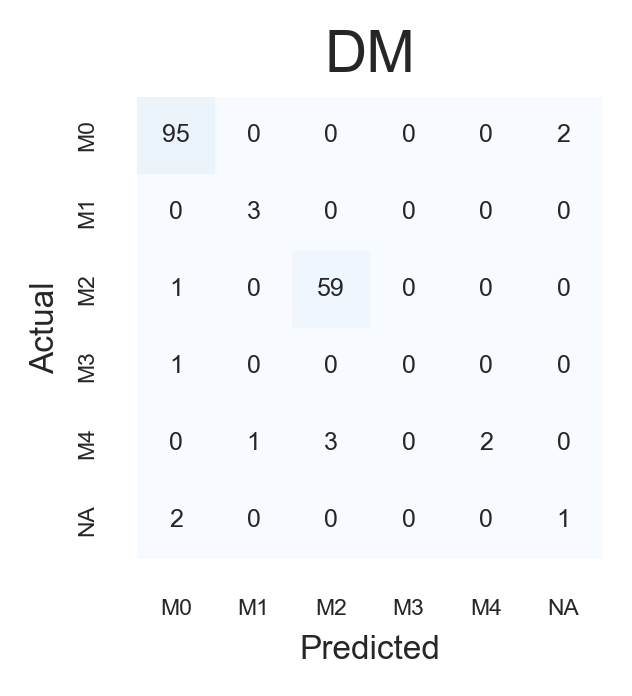

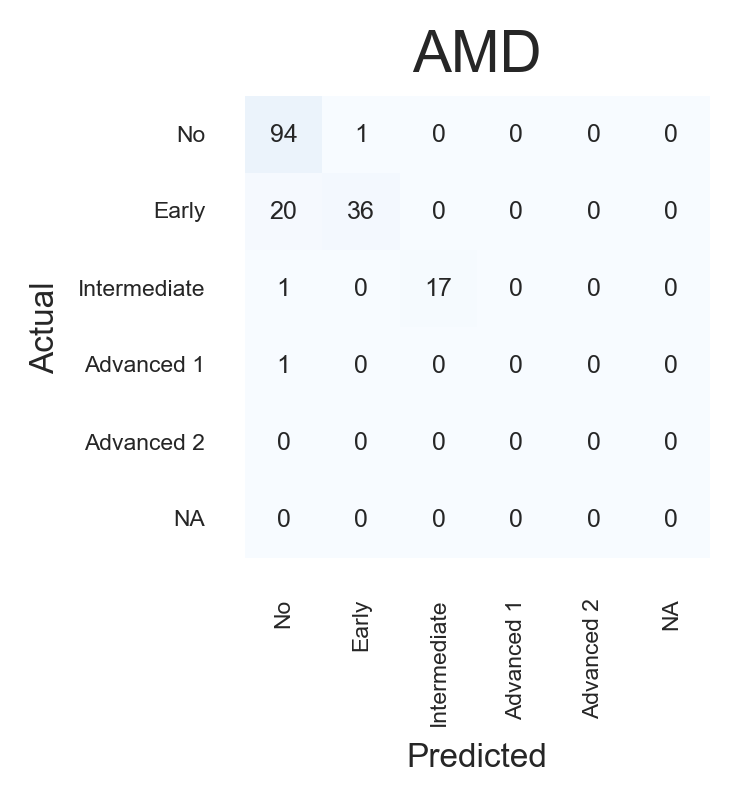

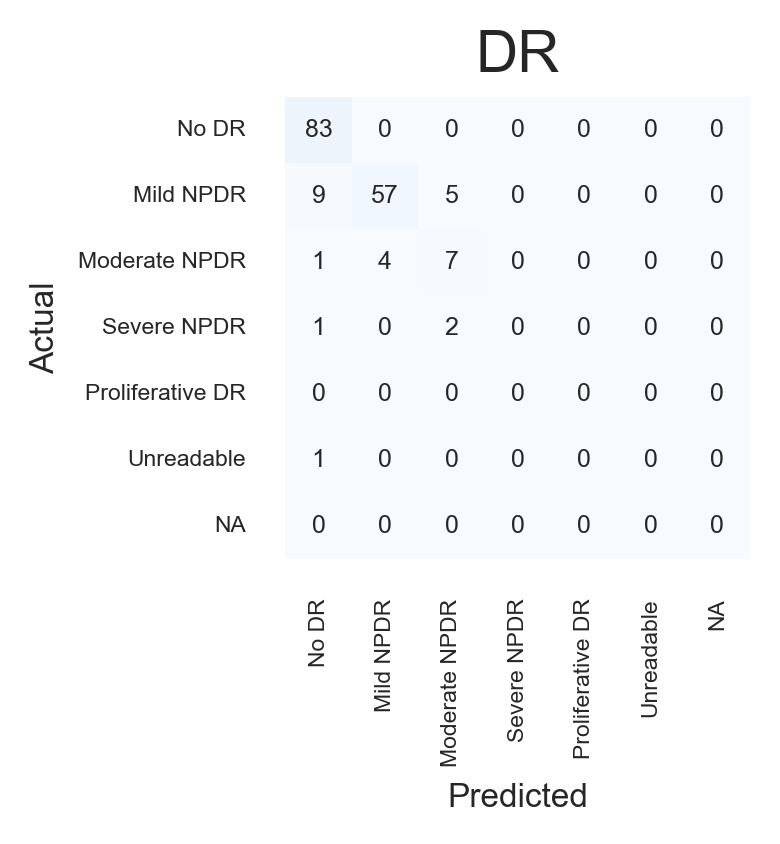

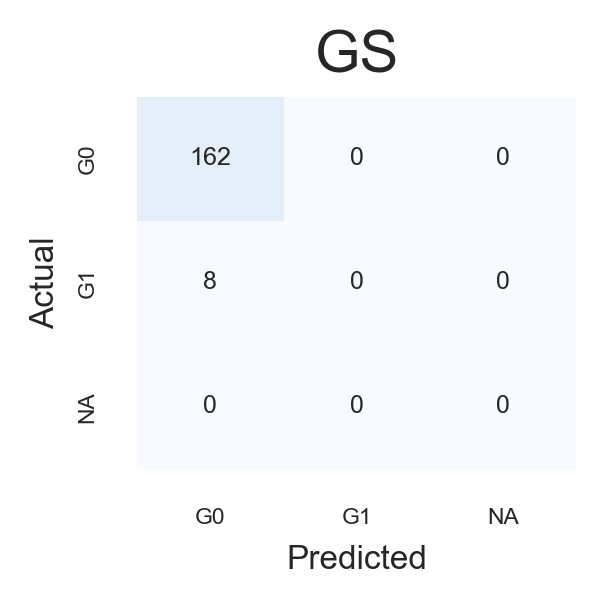

,M0,M1,M2,M3,M4,NA
M0,91,0,0,0,0,1
M1,0,17,0,0,0,0
M2,0,0,50,0,0,0
M3,0,1,0,0,0,0
M4,0,0,1,0,0,0
NA,8,0,0,0,0,1


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,71,1,0,0,0,0
Early,18,48,0,0,0,0
Intermediate,0,0,30,0,0,0
Advanced 1,0,0,1,0,0,0
Advanced 2,1,0,0,0,0,0
NA,0,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,86,0,0,0,0,0,0
Mild NPDR,2,63,2,0,0,0,0
Moderate NPDR,2,3,7,0,0,0,0
Severe NPDR,1,0,2,0,0,0,0
Proliferative DR,1,0,0,0,0,0,0
Unreadable,1,0,0,0,0,0,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,165,0,0
G1,4,0,0
NA,1,0,0


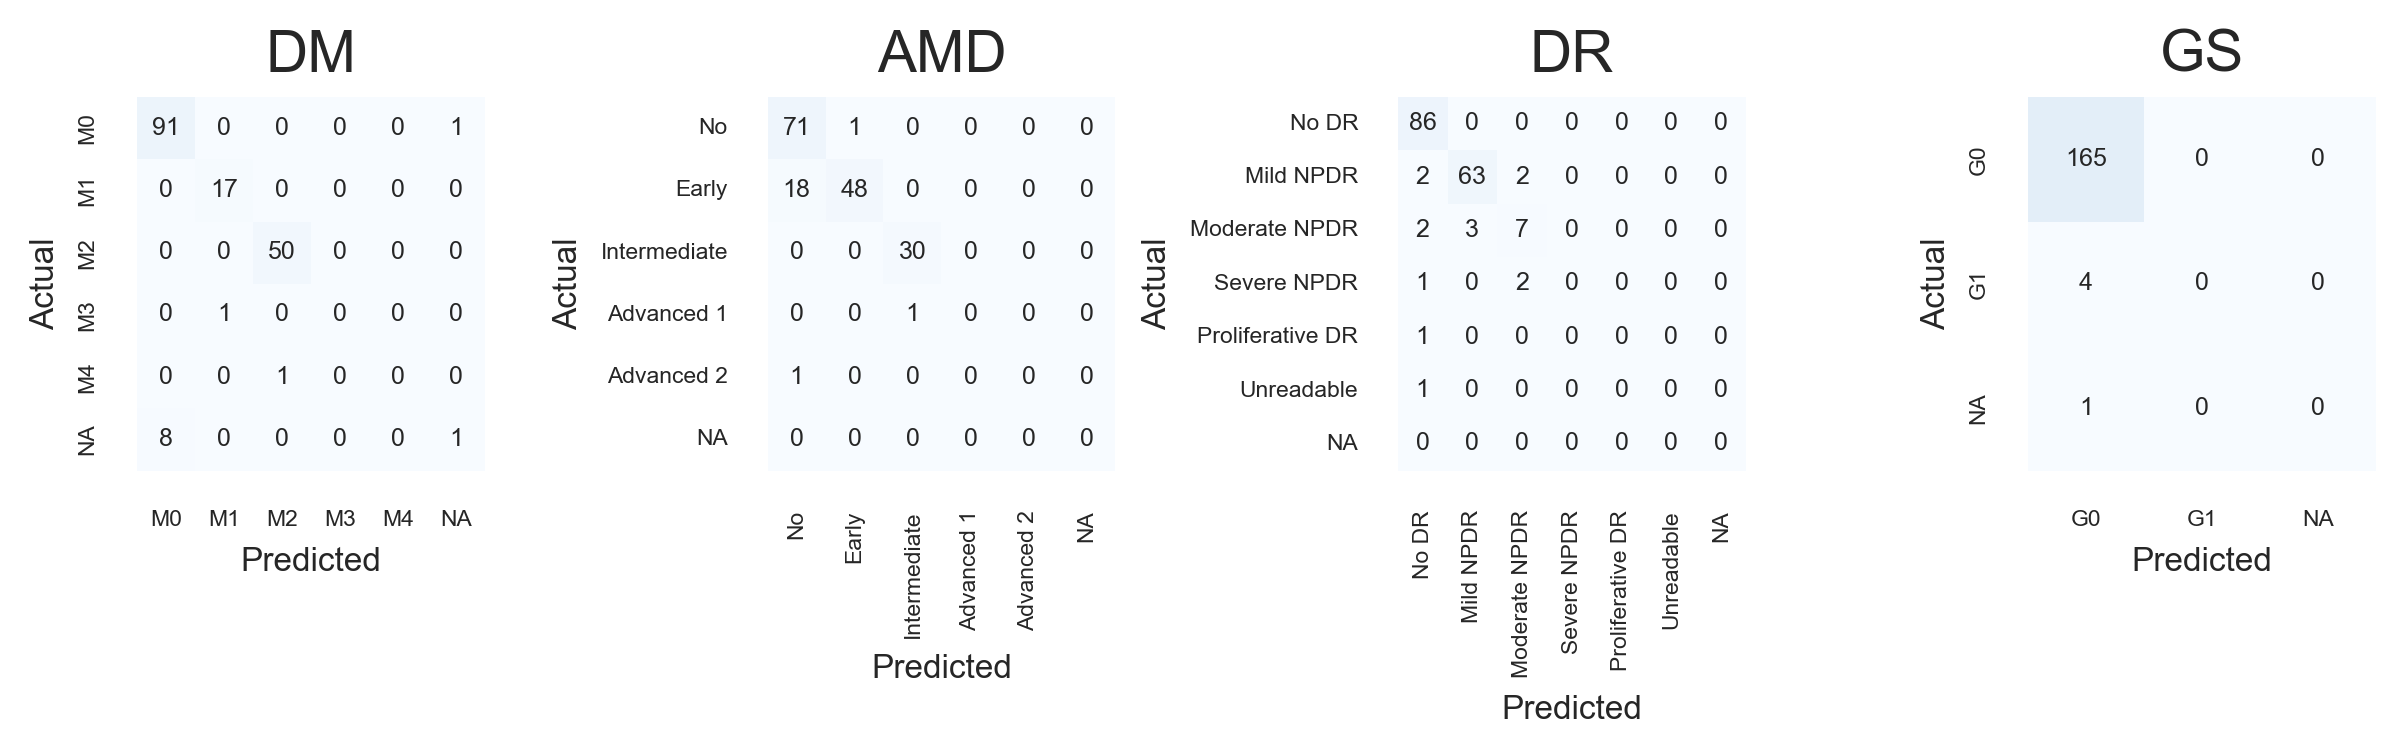

,M0,M1,M2,M3,M4,NA
M0,91,0,0,0,0,1
M1,0,17,0,0,0,0
M2,0,0,50,0,0,0
M3,0,1,0,0,0,0
M4,0,0,1,0,0,0
NA,8,0,0,0,0,1


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,71,1,0,0,0,0
Early,18,48,0,0,0,0
Intermediate,0,0,30,0,0,0
Advanced 1,0,0,1,0,0,0
Advanced 2,1,0,0,0,0,0
NA,0,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,86,0,0,0,0,0,0
Mild NPDR,2,63,2,0,0,0,0
Moderate NPDR,2,3,7,0,0,0,0
Severe NPDR,1,0,2,0,0,0,0
Proliferative DR,1,0,0,0,0,0,0
Unreadable,1,0,0,0,0,0,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,165,0,0
G1,4,0,0
NA,1,0,0


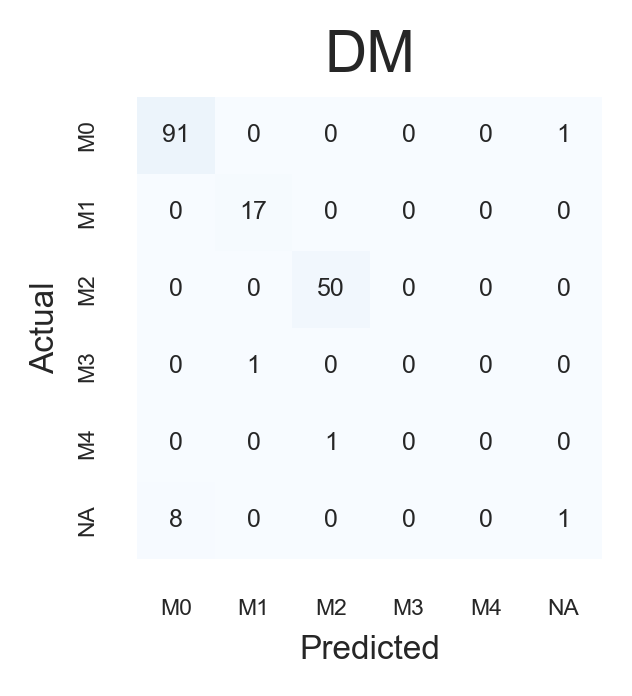

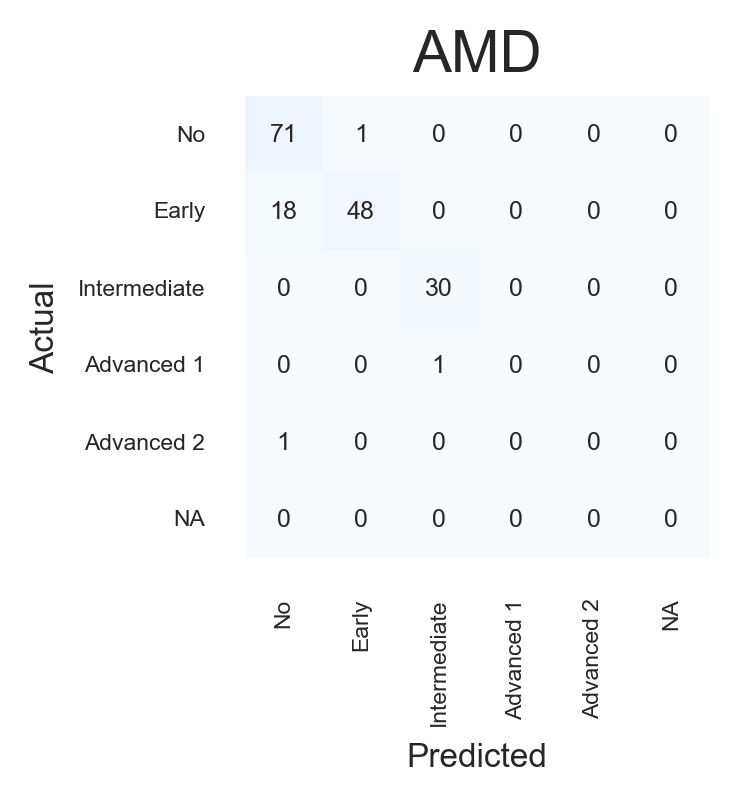

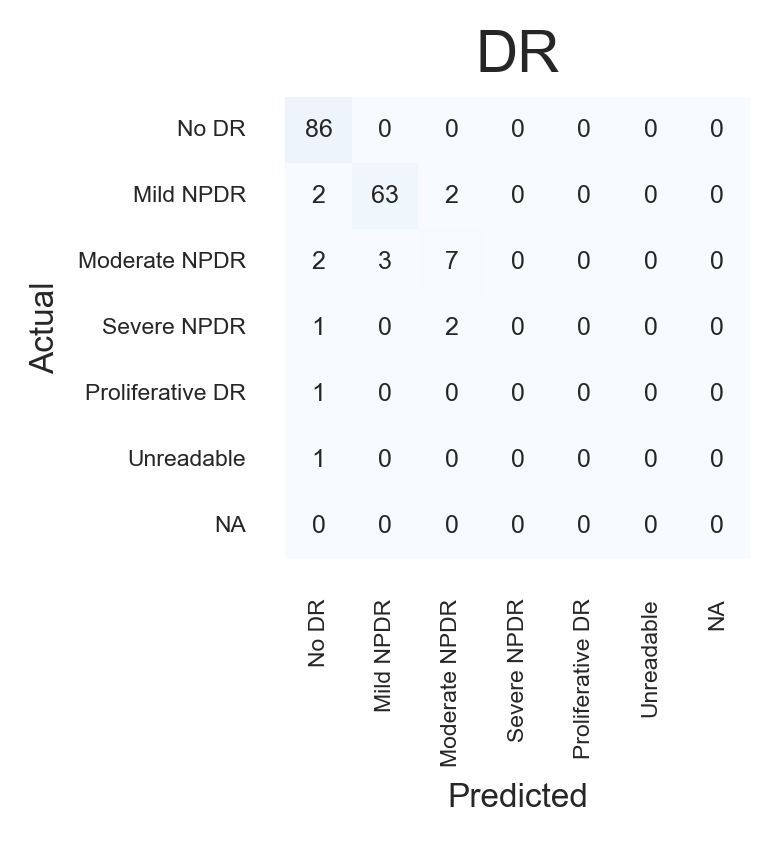

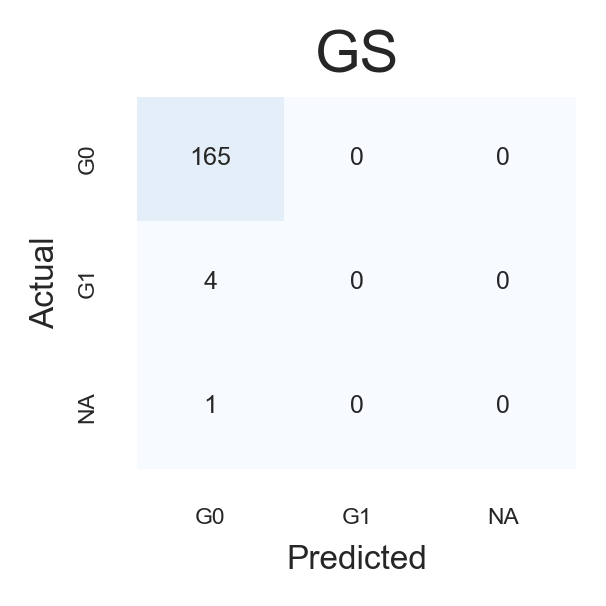

,M0,M1,M2,M3,M4,NA
M0,766,0,0,0,0,4
M1,0,67,0,0,0,0
M2,0,0,398,0,0,0
M3,0,5,0,0,2,0
M4,0,21,9,0,11,0
NA,42,0,0,0,0,31


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,742,0,0,0,0,0
Early,107,329,0,0,0,0
Intermediate,0,1,170,0,0,0
Advanced 1,0,0,2,0,0,0
Advanced 2,1,0,0,0,0,0
NA,4,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,682,2,0,0,0,0,0
Mild NPDR,38,409,23,0,0,0,0
Moderate NPDR,24,62,54,0,0,0,0
Severe NPDR,2,2,21,0,0,0,0
Proliferative DR,1,0,1,0,0,0,0
Unreadable,34,0,0,0,0,1,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,1283,0,0
G1,49,0,0
NA,24,0,0


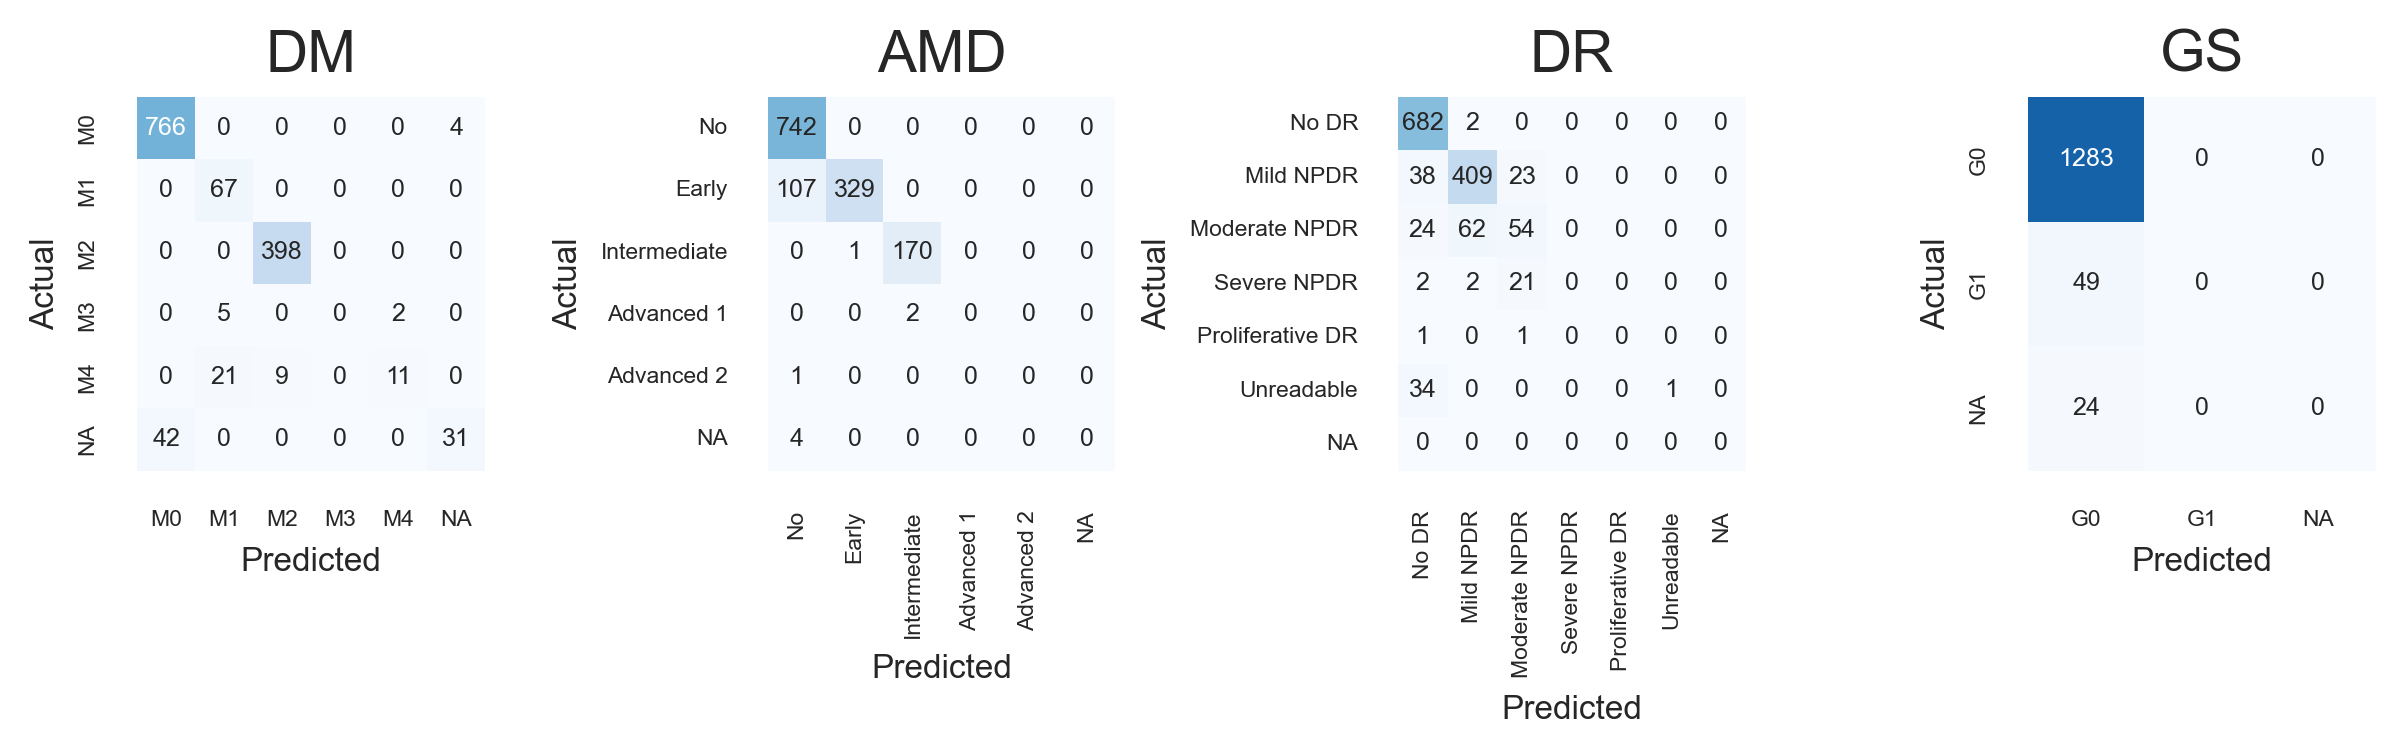

,M0,M1,M2,M3,M4,NA
M0,766,0,0,0,0,4
M1,0,67,0,0,0,0
M2,0,0,398,0,0,0
M3,0,5,0,0,2,0
M4,0,21,9,0,11,0
NA,42,0,0,0,0,31


,No,Early,Intermediate,Advanced 1,Advanced 2,NA
No,742,0,0,0,0,0
Early,107,329,0,0,0,0
Intermediate,0,1,170,0,0,0
Advanced 1,0,0,2,0,0,0
Advanced 2,1,0,0,0,0,0
NA,4,0,0,0,0,0


,No DR,Mild NPDR,Moderate NPDR,Severe NPDR,Proliferative DR,Unreadable,NA
No DR,682,2,0,0,0,0,0
Mild NPDR,38,409,23,0,0,0,0
Moderate NPDR,24,62,54,0,0,0,0
Severe NPDR,2,2,21,0,0,0,0
Proliferative DR,1,0,1,0,0,0,0
Unreadable,34,0,0,0,0,1,0
NA,0,0,0,0,0,0,0


,G0,G1,NA
G0,1283,0,0
G1,49,0,0
NA,24,0,0


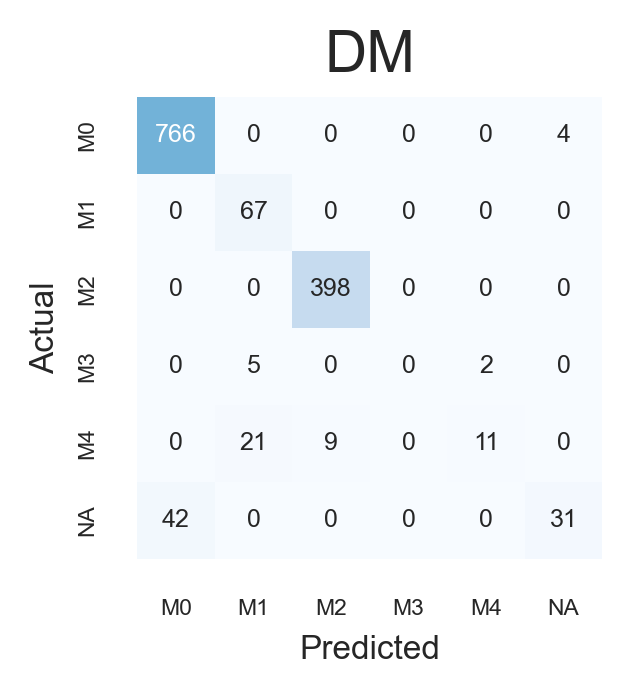

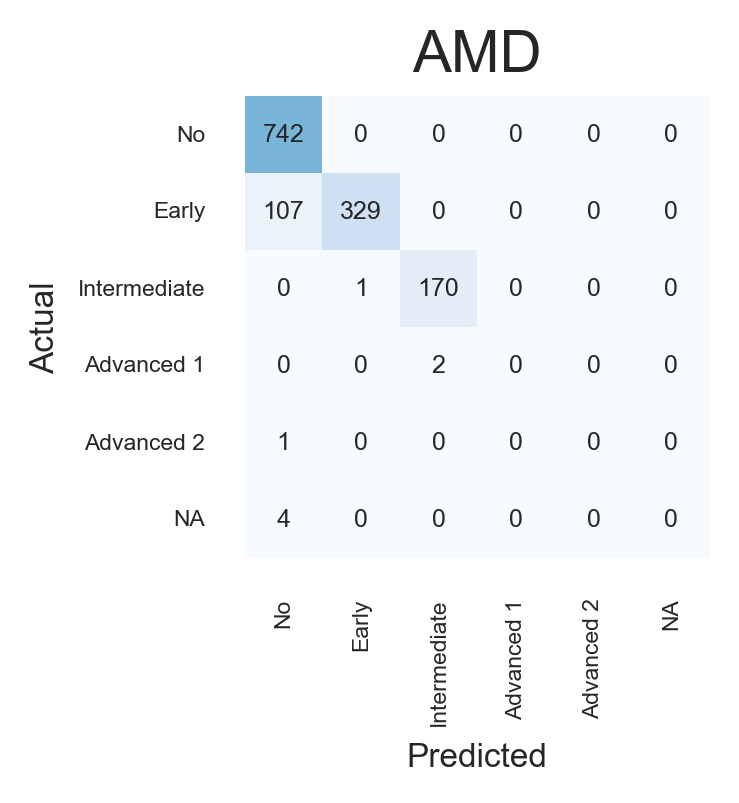

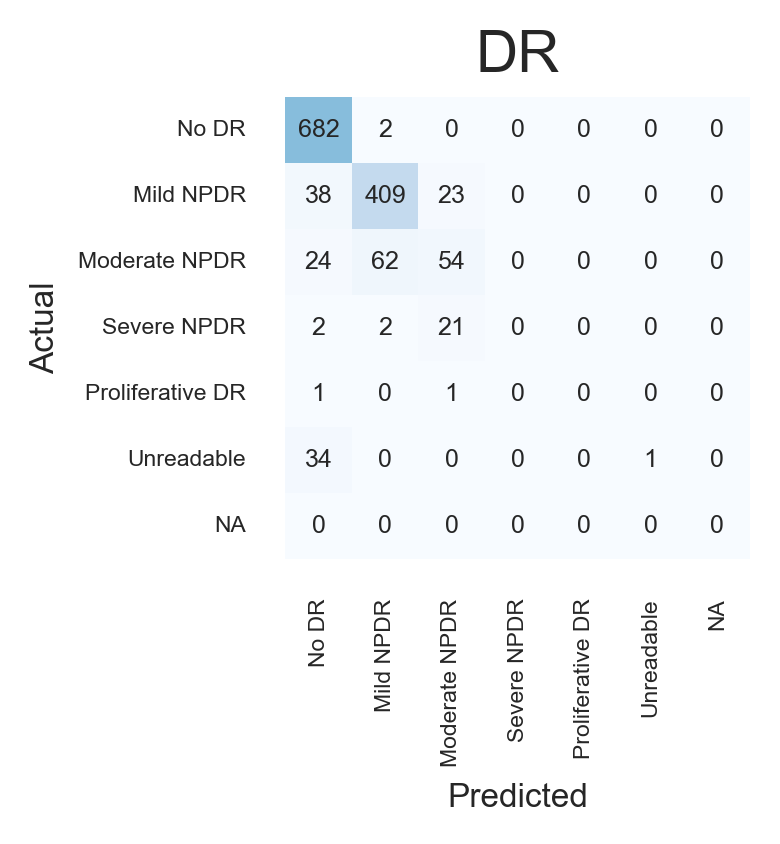

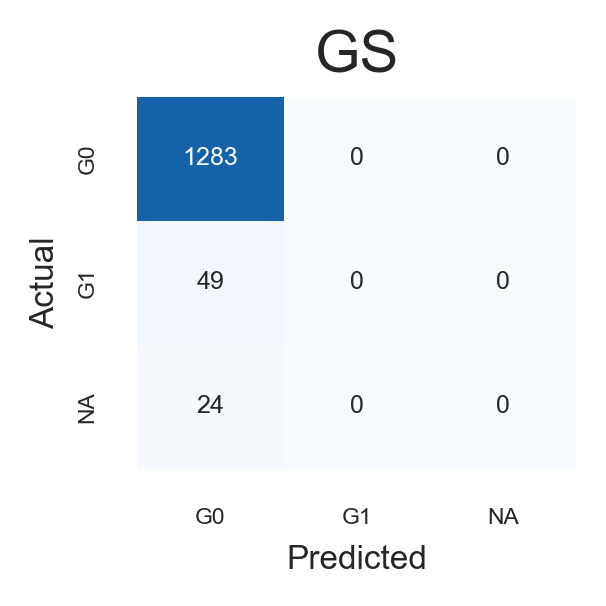

,Vision Test LE,VA LE,IOP LE,Gradable LE,Cup Disc Ratio LE,OCT RNFL_Abnormal (Progressing) LE,OCT RNFL_Abnormal (Stable) LE,OCT RNFL_Normal LE,OCT RNFL_Unreliable LE,OCT RNFL_nan LE,...,Total_Time >= 1.0 RE_fc,Total_Time >= 4.33 RE_fc,Total_Time >= 13.0 RE_fc,Total_Time >= 26.0 RE_fc,Total_Time >= 52.0 RE_fc,Total_Time >= 1.0_pred,Total_Time >= 4.33_pred,Total_Time >= 13.0_pred,Total_Time >= 26.0_pred,Total_Time >= 52.0_pred
274,1.0,0.000000,0.769231,1.0,0.894737,1,0,0,0,0,...,0.999896,0.995356,0.960742,0.054196,0.016698,0.999791,0.990890,0.927498,0.003610,0.000361
126,0.0,0.000000,0.307692,1.0,0.736842,0,0,0,0,1,...,0.999903,0.998833,0.998883,0.982491,0.988252,0.999804,0.997679,0.997799,0.965873,0.977071
261,1.0,0.000000,0.461538,1.0,0.736842,0,0,0,0,1,...,0.999892,0.998788,0.998592,0.973110,0.973900,0.999784,0.997583,0.997195,0.946841,0.947913
472,0.0,0.222222,0.461538,1.0,0.842105,0,0,0,0,1,...,0.999779,0.999517,0.989441,0.883851,0.001906,0.999548,0.999033,0.979345,0.786559,0.000004
648,0.0,0.333333,0.692308,1.0,0.684211,0,0,0,0,1,...,0.999903,0.998844,0.998900,0.982836,0.988533,0.999805,0.997692,0.997812,0.966154,0.977326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,0.0,0.000000,0.923077,1.0,0.789474,0,0,0,0,1,...,0.999921,0.999845,0.998059,0.962226,0.006283,0.999843,0.999689,0.996077,0.924999,0.000038
652,0.0,0.111111,0.461538,1.0,0.894737,0,0,1,0,0,...,0.999898,0.995440,0.959326,0.050420,0.014185,0.999788,0.991239,0.934380,0.005398,0.000588
620,0.0,0.000000,0.307692,0.0,0.736842,0,0,0,0,1,...,0.999567,0.998515,0.998847,0.989266,0.990586,0.999169,0.995707,0.996898,0.964505,0.975231
516,0.0,0.333333,0.538462,1.0,0.789474,0,0,0,0,1,...,0.999896,0.998692,0.998328,0.967055,0.967501,0.999823,0.998524,0.995913,0.920177,0.004952


,Reconstruction Error,Intermediate Binary Crossentropy,Final Binary Crossentropy
Train,0.000306,0.091672,0.103679
Validation,0.001105,0.085105,0.205038
Test,0.001737,0.100270,0.104631


In [50]:
pred_df, prediction_performance_df = evaluate_final_model(
    fc_bilateral_model, **data_dfs, intermediate_col_dict=intermediate_col_dict, seed=seed_no,
    fp_checkpoint_folder=fp_checkpoint_folder
)
display(pred_df)
display(prediction_performance_df)